# Drawing Texts

This notebook demonstrates basic text rendering APIs.

In [1]:
import skia
import contextlib
from IPython.display import display, Image

@contextlib.contextmanager
def draw_target(width=256, height=128):
    surface = skia.Surface(width, height)
    canvas = surface.getCanvas()
    yield canvas
    image = surface.makeImageSnapshot()
    display(Image(data=image.encodeToData()))

In Skia, texts can be drawn onto a canvas via `drawString()` or `drawTextBlob()`. `TextBlob` combines multiple text runs into an immutable container, and allows finer control of glyphs, paint, and positions for each run. The following example shows `drawString()` and `drawTextBlob()` with position specifications.

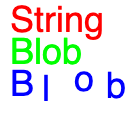

In [2]:
with draw_target(128, 128) as canvas:
    paint = skia.Paint(AntiAlias=True, Color=skia.ColorRED)
    canvas.drawString('String', 10, 32, skia.Font(None, 36), paint)
    
    paint.setColor(skia.ColorGREEN)
    blob = skia.TextBlob('Blob', skia.Font(None, 36))
    canvas.drawTextBlob(blob, 10, 64, paint)
    
    paint.setColor(skia.ColorBLUE)
    blob = skia.TextBlob('Blob', skia.Font(None, 36), [(0, 0), (32, 5), (64, -5), (96, 2)])
    canvas.drawTextBlob(blob, 10, 96, paint)

## TextBlob

`TextBlob` can be constructed with optional positions or geometric transforms. `RSXform` is a compressed form of rotation+scale matrix.

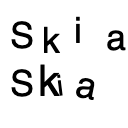

In [3]:
with draw_target(128, 128) as canvas:
    paint = skia.Paint(AntiAlias=True)
    
    blob = skia.TextBlob('Skia', skia.Font(None, 36), [(0, 0), (32, 5), (64, -5), (96, 2)])
    canvas.drawTextBlob(blob, 10, 48, paint)
    
    xform = [
        skia.RSXform(1, 0, 0, 0),
        skia.RSXform(1.2, 0, 28, 0),
        skia.RSXform(0.8, -0.1, 48, 0),
        skia.RSXform(1, 0.2, 64, 0),
    ]
    blob = skia.TextBlob.MakeFromRSXform('Skia', xform, skia.Font(None, 36))
    canvas.drawTextBlob(blob, 10, 96, paint)

To build a `TextBlob` with multiple runs, use `TextBlobBuilder`. On drawing, all runs share the same `Paint`.

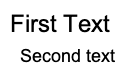

In [4]:
with draw_target(128, 64) as canvas:
    builder = skia.TextBlobBuilder()
    builder.allocRun('First Text', skia.Font(skia.Typeface('Arial'), 24), 0, 0)
    builder.allocRun('Second text', skia.Font(skia.Typeface('Arial'), 18), 10, 30)
    blob = builder.make()
    canvas.drawTextBlob(blob, 10, 32, skia.Paint(AntiAlias=True))

Runs in the blob do not contain text itself, but only glyph indices:

In [5]:
list(blob)

[Run([41, 76, 85, 86, 87, 3, 55, 72, 91, 87]),
 Run([54, 72, 70, 82, 81, 71, 3, 87, 72, 91, 87])]

Multiple runs with geometric parameters requires explicit conversion of text to glyphs.

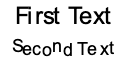

In [6]:
import random

with draw_target(128, 64) as canvas:
    builder = skia.TextBlobBuilder()
    
    font = skia.Font(skia.Typeface('Arial'), 24)
    glyphs = font.textToGlyphs('First Text')
    xpositions = font.getXPos(glyphs)
    xpositions = [x + 5 * random.random() for x in xpositions]
    builder.allocRunPosH(font, glyphs, xpositions, 0)
    
    line_height = font.getSpacing()
    
    font = skia.Font(skia.Typeface('Arial'), 18)
    glyphs = font.textToGlyphs('Second Text')
    positions = font.getPos(glyphs, origin=(0, line_height))
    positions = [
        skia.Point(
            p.x() + 3 * random.random(),
            p.y() + 5 * random.random())
        for i, p in enumerate(positions)]
    builder.allocRunPos(font, glyphs, positions)
    
    blob = builder.make()
    paint = skia.Paint(AntiAlias=True)
    canvas.drawTextBlob(blob, 10, 24, paint)

## Font and Typeface

`Typeface` specifies the typeface and intrinsic style of a font. `Font` contains `Typeface` and control options applied when drawing and measuring text, such as size information.

In [7]:
bold_typeface = skia.Typeface('Arial', skia.FontStyle.Bold())
italic_typeface = skia.Typeface('Arial', skia.FontStyle.Italic())
print(bold_typeface)
print(italic_typeface)

font = skia.Font(skia.Typeface('Times New Roman'), 24)
print(font)

Typeface('Arial', FontStyle(700, 5, Slant.kUpright_Slant))
Typeface('Arial', FontStyle(400, 5, Slant.kItalic_Slant))
Font(Typeface('Times New Roman', FontStyle(400, 5, Slant.kUpright_Slant)), 24.0, 1.0, 0.0)


Use `Font` to measure various geometry of drawn texts. `measureText` calculates the advance of the text:

In [8]:
font.measureText('text')

35.98828125

Recommended line height is given by `getSpacing`:

In [9]:
font.getSpacing()

27.59765625

For detailed metrics of geometric measurement, obtain `FontMetrics` object.

In [10]:
font.getMetrics()

FontMetrics(Flags=3, Top=-24.1641, Ascent=-21.3867, Descent=5.19141, Bottom=7.35938, Leading=1.01953, AvgCharWidth=61.6406, MaxCharWidth=61.6406, XMin=-13.6406, XMax=48, XHeight=10.7344, CapHeight=15.8906, UnderlineThickness=1.17188, UnderlinePosition=2.61328, StrikeoutThickness=-5.38825e-33, StrikeoutPosition=4.59163e-41)

On drawing, texts are represented by `glyphs`. `Typeface` maintains character to glyph mapping. Unicode texts are mapped one-by-one to glyph indices.

In [11]:
glyphs = font.textToGlyphs('text')
glyphs

[87, 72, 91, 87]

`glyph` positions and bounding boxes are given by `getPos` and `getBounds`:

In [12]:
print(font.getPos(glyphs, origin=(10, 10)))
print(font.getBounds(glyphs))

[Point(10, 10), Point(16.668, 10), Point(27.3203, 10), Point(39.3203, 10)]
[Rect(-1, -16, 8, 2), Rect(-1, -13, 11, 2), Rect(-1, -12, 13, 1), Rect(-1, -16, 8, 2)]


Glyphs can be converted to `Path` objects.

In [15]:
font.getPaths(glyphs)

## FontMgr

List of available font families can be retrieved by `FontMgr`.

In [25]:
fontmgr = skia.FontMgr()
list(fontmgr)[:10]

['Abadi MT Condensed Extra Bold',
 'Abadi MT Condensed Light',
 'Al Bayan',
 'Al Nile',
 'Al Tarikh',
 'American Typewriter',
 'Andale Mono',
 'Arial',
 'Arial Black',
 'Arial Hebrew']

Each font has specific style presets. For example, `Helvetica` font has 6 styles.

In [26]:
styles = fontmgr.matchFamily('Helvetica')
list(styles)

[(FontStyle(400, 5, Slant.kUpright_Slant), 'Regular'),
 (FontStyle(400, 5, Slant.kItalic_Slant), 'Oblique'),
 (FontStyle(300, 5, Slant.kUpright_Slant), 'Light'),
 (FontStyle(300, 5, Slant.kItalic_Slant), 'Light Oblique'),
 (FontStyle(700, 5, Slant.kUpright_Slant), 'Bold'),
 (FontStyle(700, 5, Slant.kItalic_Slant), 'Bold Oblique')]

Once a font family and a style is determined, `Typeface` object can be created:

In [18]:
styles.createTypeface(4)

Typeface('Helvetica', FontStyle(700, 5, Slant.kUpright_Slant))

Alternatively, `FontMgr` can look for closest face.

In [19]:
typeface = fontmgr.matchFamilyStyle('Arial', skia.FontStyle.Normal())
typeface

Typeface('Arial', FontStyle(400, 5, Slant.kUpright_Slant))